In [1]:
import caffe
import os
from pylab import *
import sys
from PIL import Image
import numpy as np
import time
from flask import Flask,request, jsonify

import cv2

%matplotlib inline

In [2]:
mean_filename='garbnet_mean.binaryproto'
deploy_filename = 'deploy_garbnet.prototxt'
caffemodel_file = 'garbnet_fcn.caffemodel'

proto_data = open(mean_filename, "rb").read()
a = caffe.io.caffe_pb2.BlobProto.FromString(proto_data)
mean  = caffe.io.blobproto_to_array(a)[0]

net = caffe.Net(deploy_filename,caffemodel_file,caffe.TEST)

In [3]:
def gatherImages(folder,imageNames=None):
    images = []
    names = []
    files = os.listdir(folder)
    total = len(files)
    print ('Total images in folder', total, folder)
    for i in os.listdir(folder):
        try:
            if imageNames is None or i in imageNames:
                example_image = folder+'/'+i
                input_image = Image.open(example_image)
                images.append(input_image)
                names.append(i)
        except:
          pass

    return images,names

def resizeForFCN(image,size):
    w,h = image.size
    if w<h:
        return image.resize((int(227*size),int((227*h*size)/w))) #227x227 is input for regular CNN
    else:
        return image.resize((int((227*w*size)/h),int(227*size)))
    
def getSegmentedImage(test_image, probMap,thresh):
    kernel = np.ones((6,6),np.uint8)
    wt,ht = test_image.size
    out_bn = np.zeros((ht,wt),dtype=uint8)
    
    for h in range(probMap.shape[0]):
                for k in range(probMap.shape[1]):
                    if probMap[h,k] > thresh:
                        x1 = h*62 #stride 2 at fc6_gb_conv equivalent to 62 pixels stride in input
                        y1 = k*62
                        for hoff in range(x1,227+x1):
                            if hoff < out_bn.shape[0]:
                                for koff in range(y1,227+y1):
                                    if koff < out_bn.shape[1]:
                                        out_bn[hoff,koff] = 255
    edge = cv2.Canny(out_bn,200,250)
    box = cv2.dilate(edge,kernel,iterations = 3)
    
    or_im_ar = np.array(test_image)
    or_im_ar[:,:,1] = (or_im_ar[:,:,1] | box)
    or_im_ar[:,:,2] = or_im_ar[:,:,2] * box + or_im_ar[:,:,2]
    or_im_ar[:,:,0] = or_im_ar[:,:,0] * box + or_im_ar[:,:,0]
    
    return Image.fromarray(or_im_ar)
    
    
def getPredictionsFor(images,names,size,thresh,output_folder):
    for i in range(len(images)):
            test_image = resizeForFCN(images[i],size)
            
            in_ = np.array(test_image,dtype = np.float32)
            in_ = in_[:,:,::-1]
            in_ -= np.array(mean.mean(1).mean(1))
            in_ = in_.transpose((2,0,1))

            net.blobs['data'].reshape(1,*in_.shape)
            net.blobs['data'].data[...] = in_
            net.forward()
            
            probMap =net.blobs['prob'].data[0,1]
            print (names[i]+'...',)
            if len(np.where(probMap>thresh)[0]) > 0:
                print ('Garbage!')
                time.sleep(5)
            else:
                print ('Not Garbage!')
                time.sleep(5)
            out_ = getSegmentedImage(test_image, probMap,thresh)
            out_.save(output_folder + '/output_' + names[i])

In [4]:
#specify 'input' folder containing images for prediction
images,names = gatherImages('input')
#specify 'output' folder to store segmented predictions
getPredictionsFor(images,names,4,0.999,'output')

Total images in folder 26 input
13.jpg...
Garbage!
6.jpg...
Garbage!
9.jpg...
Garbage!
2.jpg...
Garbage!
17.jpg...
Garbage!
14.jpg...
Garbage!
sample_2_garbage.jpg...
Garbage!
sample_4_nongarbage.jpg...
Not Garbage!
4.jpg...
Garbage!
5.jpg...
Garbage!
3.jpg...
Garbage!
sample_3_garbage.jpg...
Garbage!


IndexError: too many indices for array

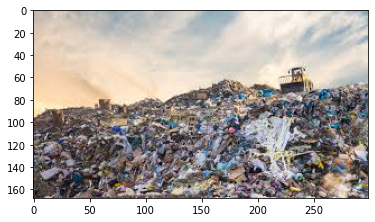

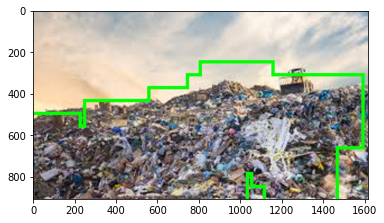

In [5]:
imshow(Image.open('input/3.jpg'))
figure()
imshow(Image.open('output/output_3.jpg'))

In [ ]:
app = Flask(__name__)
@app.route("/",methods=['GET'])
def appd():
  if request.method=="GET":

      folder='input'
      imageNames=None
      images = []
      names = []
      files = os.listdir(folder)
      total = len(files)
      print ('Total images in folder', total, folder)
      for i in os.listdir(folder):
          try:
              if imageNames is None or i in imageNames:
                  example_image = folder+'/'+i
                  input_image = Image.open(example_image)
                  images.append(input_image)
                  names.append(i)
          except:
              pass

      #--------------------------------------------------------------------------------
      size=4
      thresh=0.999
      output_folder='output'
      for i in range(len(images)):
          w,h = images[i].size
          if w<h:
              test_image= images[i].resize((int(227*size),int((227*h*size)/w))) #227x227 is input for regular CNN
          else:
              test_image= images[i].resize((int((227*w*size)/h),int(227*size)))
        
          in_ = np.array(test_image,dtype = np.float32)
          in_ = in_[:,:,::-1]
          in_ -= np.array(mean.mean(1).mean(1))
          in_ = in_.transpose((2,0,1))

          net.blobs['data'].reshape(1,*in_.shape)
          net.blobs['data'].data[...] = in_
          net.forward()
          probMap =net.blobs['prob'].data[0,1]
          print (names[i]+'...',)
          if len(np.where(probMap>thresh)[0]) > 0:
                print ('Garbage!')
          else:
                print ('Not Garbage!')
          kernel = np.ones((6,6),np.uint8)
          wt,ht = test_image.size
          out_bn = np.zeros((ht,wt),dtype=uint8)

          for h in range(probMap.shape[0]):
                for k in range(probMap.shape[1]):
                      if probMap[h,k] > thresh:
                            x1 = h*62 #stride 2 at fc6_gb_conv equivalent to 62 pixels stride in input
                            y1 = k*62
                            for hoff in range(x1,227+x1):
                                  if hoff < out_bn.shape[0]:
                                      for koff in range(y1,227+y1):
                                          if koff < out_bn.shape[1]:
                                              out_bn[hoff,koff] = 255
          edge = cv2.Canny(out_bn,200,250)
          box = cv2.dilate(edge,kernel,iterations = 3)

          or_im_ar = np.array(test_image)
          or_im_ar[:,:,1] = (or_im_ar[:,:,1] | box)
          or_im_ar[:,:,2] = or_im_ar[:,:,2] * box + or_im_ar[:,:,2]
          or_im_ar[:,:,0] = or_im_ar[:,:,0] * box + or_im_ar[:,:,0]

          out_= Image.fromarray(or_im_ar)
          out_.save(output_folder + '/output_' + names[i])
          #specify 'input' folder containing images for prediction
          #images,names = gatherImages('input')
          #specify 'output' folder to store segmented predictions
          #getPredictionsFor(images,names,4,0.999,'output')
          return jsonify(12345)
app.run(host='0.0.0.0',port=9090)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:9090/ (Press CTRL+C to quit)


Total images in folder 26 input
13.jpg...
Garbage!


139.167.223.247 - - [09/Oct/2020 13:21:52] "GET / HTTP/1.1" 200 -
139.167.223.247 - - [09/Oct/2020 13:21:53] "GET /favicon.ico HTTP/1.1" 404 -
